# Predictive Cloud Auto Scaling Based on CPU Load Using Linear Regression

### Overview

Cloud based systems have varying load throughout the day. The time of day, the day of the month, the time of year, some or all might play a role in the amount of load being put on the system. Therefore, it is crucial to have the necessary number of servers/virtual machine (VM) instances/Kubernetes pods to ensure service availability and better response times. However, it can hard and tedious to understand what is the appropriate number instances a system should have at a specific time. You also have to consider that having a high number of instances during idle time can drive up cost.

This notebook explores how data driven methods, specifically Linear Regression, can help alleviate this problem using CPU loads and how a system could make decision based on its prediction.

We'll simulate a simple environment where:
* CPU utilization varies over time.
* A reactive autoscaling strategy is used to balance load.
* A linear regression model is trained on historical load data (simulated) to forcast future CPU usage.
* The forecast is used to simulate auto scaling using a predictive strategy.

#### Learning Objectives

By the end of this notebook, you will:
* Understand how linear regression can be applied to CPU utilization time series.
* Simulate and compare reactive vs predictive auto scaling strategies.
* Identify a common design mistake in scaling logic and how to debug it.

### Data Simulation

In this section, we are going to simulate the CPU load of a system during a 24 hour window. This will simulate a scenario where the system starts with low load during the morning, slowly rises to high load throughout the day, reaching peak load at 11:00. Then the load will gradually reduce throughout the evening and reach the lowest load at night.

Noise has been added to make the load more realistic. There are also sudden spikes throughout the day which is common for a real world system.

Lets start by importing the necessary python modules.

In [ ]:
import numpy as np                  # For numerical operations
import pandas as pd                 # For data visualization
import matplotlib.pyplot as plt     # For plotting

Now we will generate the base load. This will generate a very simple piecewise linear graph, which is not a very good representation of a real load on a production system. Think of this as a rough pencil sketch before the actual details get put into place. If you want to see what this graph looks like, execute the next cell without executing the noise and spike cells and then plot the graph.

In [201]:
# Using a fixed random seed for reproducibility
np.random.seed(40)

minutes = 24 * 60  # 24 hours in minutes
time = np.arange(minutes)

# Initializing CPU load
cpu_load = np.zeros(minutes)

# Defining the boundaries for each linear graph segment
initial = 240           # 00:00 - 04:00 hours
ramp_up_end = 660       # 04:00 - 11:00 hours
peak_end = 900          # 11:00 - 15:00 hours
ramp_down_end = 1260    # 15:00 - 21:00 hours
idle_end = 1440         # 21:00 - 00:00 hours

cpu_load[:initial] = 10 # Idle CPU load is at 10% usage

# Ramp-up: 10% to 80%
cpu_load[initial:ramp_up_end] = np.linspace(10, 80, ramp_up_end - initial)

# Peak usage: 80%
cpu_load[ramp_up_end:peak_end] = 80 # Peak CPU load is at 80% usage

# Ramp-down: 80% to 10%
cpu_load[peak_end:ramp_down_end] = np.linspace(80, 10, ramp_down_end - peak_end)

# Idle: 10%
cpu_load[ramp_down_end:idle_end] = 10

Here, we are adding noise to the base load to make it more realistic. In a real system, there isn't just the one process that uses the resources of the system. There usually is other background processes and CPU load fluctuates. Adding random noise helps to simulate that fact.
> Dev Note: Tested with different types of distributions and found normal distribution to give the best graph.

In [202]:
noise = np.random.normal(0, 5, size=minutes)
cpu_load += noise

Now, in a real system, there are times in a day when there can be a surge of users using the system or maybe theres a scheduled task that runs in the background. During these times, there are random spikes in CPU usage. To simulate this behaviour, we are going to add random spikes to the data at random intervals throughout the day.

In [203]:
spikes = np.zeros(minutes)
for _ in range(np.random.randint(5, 10)):
    start = np.random.randint(0, minutes - 15) # Choosing a random start time
    duration = np.random.randint(3, 15) # How long the spike lasts
    spikes[start:start+duration] += np.random.randint(15, 40)

cpu_load += spikes

We now have the necessary simulation data in `cpu_load`. However, the CPU load is in percentage and therefore there cannot be any load below 0 or above 100. The noise and spike we have added may make some data points exceed this boundary. As a result, we are going to make sure that any data below 0 is set to 0 and any data above 100 is set to 100 using the clip function of numpy.

In [204]:
cpu_load = np.clip(cpu_load, 0, 100)

Now that we have our data, lets visualize it using pandas and matplotlib.

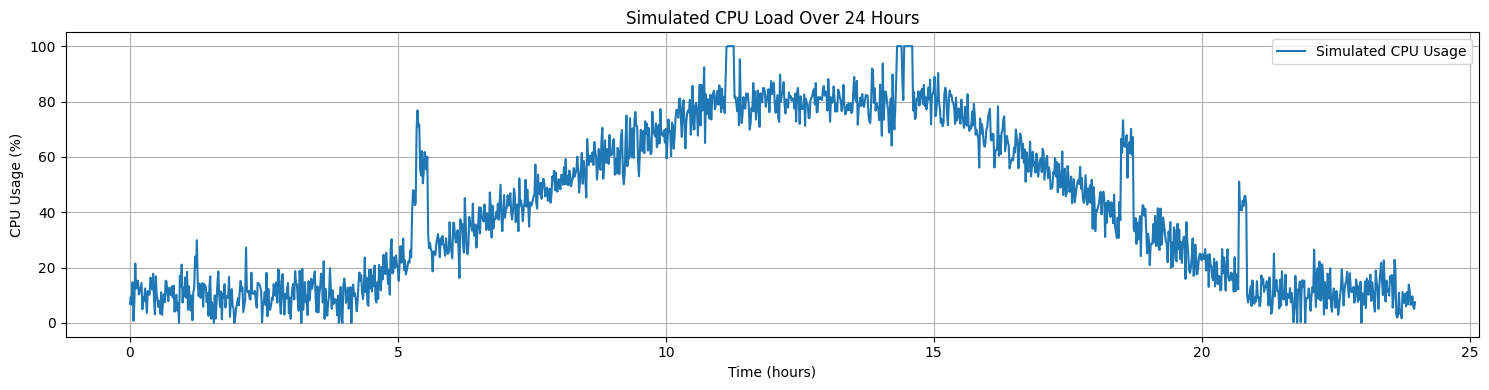

In [ ]:
# Create DataFrame
cpu_load_df = pd.DataFrame({
    'minute': time,
    'cpu_usage': cpu_load
})

# Plot the result
plt.figure(figsize=(15, 4))
plt.plot(cpu_load_df['minute']/60, cpu_load_df['cpu_usage'], label='Simulated CPU Usage')
plt.xlabel('Time (hours)')
plt.ylabel('CPU Usage (%)')
plt.title('Simulated CPU Load Over 24 Hours')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Reactive Auto Scaling

##### What is Reactive Auto Scaling?
Reactive auto scaling is a auto scaling approach where rules are made to scale up or down instances based on a metric, such as CPU load. Threshold values are set and whenever these values are crossed, the auto scaler will either scale up or scale down. It is important to understand that this strategy only uses the data in the current time to make decisions.

Lets start by first defining the parameters of the approach.

In [225]:
scale_up_threshold = 70     # in percentage
scale_down_threshold = 20   # in percentage
cooldown_period = 1         # in minutes

min_instances = 1           # Minimum number of instances
instances = [1]             # This will be a list to track instances over time. Start with one instance

last_scale_time = 0         # Used to track the last scaling time

Now that we have the necessary parameters, lets start auto scaling.

In [ ]:
for t in range(1, len(cpu_load_df)):
    current_cpu = cpu_load_df['cpu_usage'].iloc[t] # Get the current CPU usage
    current_instances = instances[-1]

    # Check if enough time has passed since the last scaling action
    if (t - last_scale_time) >= cooldown_period:
        if current_cpu > scale_up_threshold:
            # Scale up
            current_instances += 1
            last_scale_time = t
        elif current_cpu < scale_down_threshold and current_instances > min_instances:
            # Scale down
            current_instances -= 1
            last_scale_time = t

    instances.append(current_instances)

We can now visualize how our reactive scaling strategy worked on the simulated CPU load data.

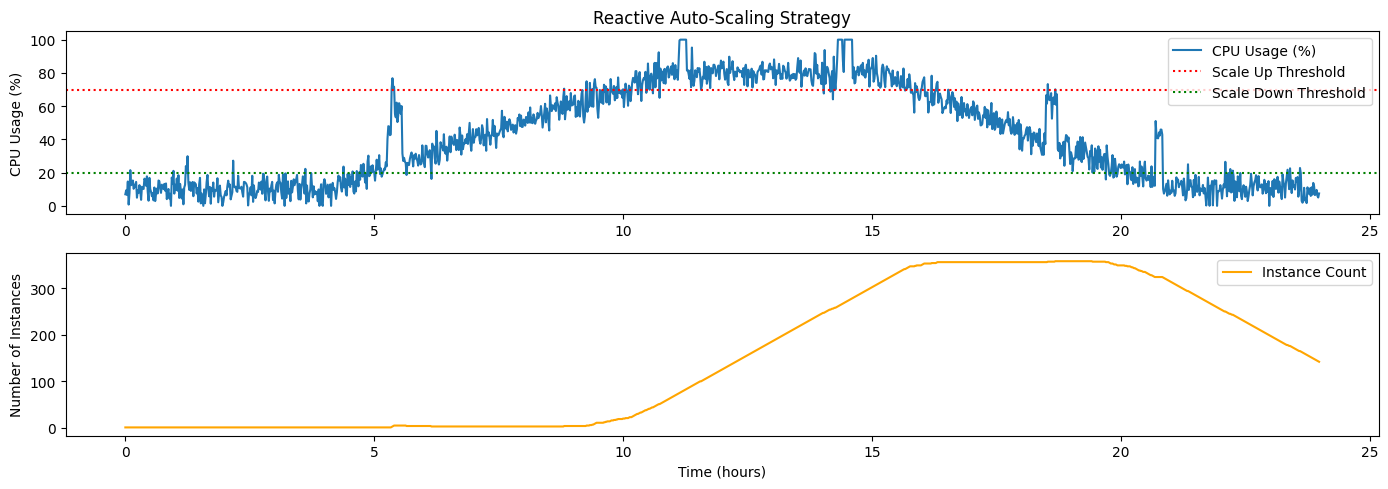

In [242]:
plt.figure(figsize=(14, 5))

# CPU usage plot
plt.subplot(2, 1, 1)
plt.plot(cpu_load_df['minute']/60, cpu_load_df['cpu_usage'], label='CPU Usage (%)')
plt.axhline(scale_up_threshold, color='red', linestyle=':', label='Scale Up Threshold')
plt.axhline(scale_down_threshold, color='green', linestyle=':', label='Scale Down Threshold')
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.title("Reactive Auto-Scaling Strategy")

# Instance count plot
plt.subplot(2, 1, 2)
plt.plot(cpu_load_df['minute']/60, instances, label='Instance Count', color='orange')
plt.xlabel("Time (hours)")
plt.ylabel("Number of Instances")
plt.legend()

plt.tight_layout()
plt.show()


As you can see, reactive auto scaling is pretty simple to implement. It is clear from the graph that it takes the auto scaler time to catch up to the increased load as evident from the right shift of the instance curve. Keep this in mind as we move to explore predictive auto scaling.